In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from quetzal.model import stepmodel

C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


# Inner-zonal trips
## Preperation of calibration data
Assignment of inner-zonal trips is not possible in a classic transport model. Trip lengths by mode and purpose must be approximated with MiD2017 data.

In [26]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

Inner-cellular mode choice will be dependent on cell-specific network data as well as trip-specific and socio-economic data. All categories must be available in the calibration data set as well as in the model.
* Accessibility by mode in this cell (weighted average, see prep33)
* Population density (population by km²)
* Road network length by km²
* Economic status of household or cell (GDP)
* Car ownership in this cell

### Load trips table from MiD and filter

In [3]:
trips = pd.read_csv(input_path + 'transport_demand/MiD2017_Regional_Wege.csv', sep=';')
trips = trips[['KKZ_SO', 'KKZ_ZO', 'wegkm_imp','wegmin_imp1',
               'hwzweck1', 'hvm_diff2', 'auto', 'W_SO2',
               'bahn28', 'bus28', 'ewqkm']] # alternatively sieddichte
trips.columns = ['origin', 'destination', 'distance', 'duration',
                 'purpose', 'mode', 'car_avail', 'W_SO2',
                 'dist_train', 'dist_bus', 'pop_density']
trips['distance'] = pd.to_numeric(trips['distance'].str.replace(',', '.'))

In [4]:
# Filter for inner-German trips
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
# Filter unspecified rows
trips = trips.loc[(trips['origin']<9999) &
                  (trips['destination']<9999) &
                  (trips['purpose']!=99) &
                  (trips['mode']<24)]
print(trips.shape)

(409507, 9)


In [5]:
# Filter for inner-cell traffic
trips = trips.loc[trips['origin']==trips['destination']]
print(trips.shape)

(300620, 9)


In [6]:
# Remove ferries
trips = trips.loc[trips['mode']!=19]
print(trips.shape)

(300585, 9)


In [7]:
# Match mode with the model modes
# Non-motorised modes are merged
# See cal10
model_modes = {1: 'rail_short_distance', 2: 'rail_long_distance',
               3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mode_mid_vp_dict = {1:7, 2:7, 3:7, 4:6, 5:6, 6:6, 7:6, 8:6,
                    9:6, 10:6, 11:6, 12:4, 13:4, 14:4, 15:4,
                    16:1, 17:6, 18:6, 19:6, 20:2, 21:3, 22:3,
                    23:5, 24:7}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

In [8]:
# Make car availability binary
trips['car_avail'] = trips['car_avail'].replace({9:0})

In [9]:
# Match trip purpose with VP2030 categories
# Note: Holiday trips are included in private (6)
# see cal10
purpose_mid_vp_dict = {1: 1, 2: 4, 3: 2, 4: 3, 5: 3, 6: 6, 7: 6, 99: 6}
trips['purpose_vp'] = trips['purpose'].map(purpose_mid_vp_dict)

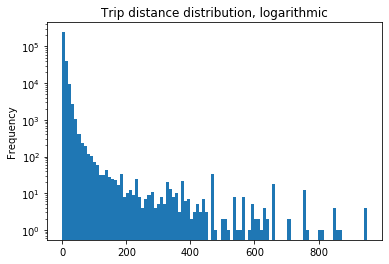

In [20]:
# Trip distance
trips['distance'].plot.hist(bins=100, log=True, title='Trip distance distribution, logarithmic')

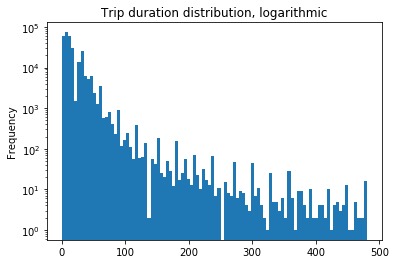

In [21]:
# Trip duration
trips['duration'].plot.hist(bins=100, log=True, title='Trip duration distribution, logarithmic')

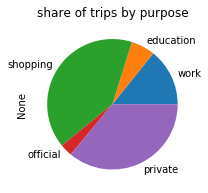

In [12]:
# Trip purpose
trips.groupby('purpose_vp').size().plot.pie(
    subplots=False,figsize=(3, 3),labels=['work', 'education', 'shopping', 'official', 'private'],
    title='share of trips by purpose')

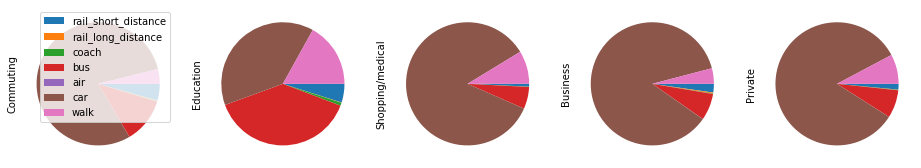

In [13]:
# Modal split
axs = trips.groupby(['mode_model','purpose_vp']).size().unstack(fill_value=0).rename(
    columns={1:'Commuting', 2:'Education', 3:'Shopping/medical', 4:'Business', 6:'Private'}).plot.pie(
    subplots=True, figsize=(16, 4), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False,
    legend=False, labeldistance=None)
axs[0].legend()

In [15]:
# Remove air and coach because their calibration
# cannot be significant due to low sample size
trips = trips.loc[(trips['mode_model']!=3) &
                  (trips['mode_model']!=5)]
print(trips.shape)

(300133, 11)


### Imputate network data to trips

In [16]:
# Loading complete StepModel...
sm = stepmodel.read_zip(model_path + 'de_los.zip')

zones: 100%|███████████████████████████████████████████████████████████████████████████| 32/32 [00:38<00:00,  1.22s/it]


In [19]:
# Replace LAU IDs with NUTS IDs in origin and destination
lau_nuts_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
trips['NUTS_ID'] = trips['origin'].astype(str).map(lau_nuts_dict)
# Drop all other trips
trips = trips.loc[trips['NUTS_ID'].notna()]
print(trips.shape)

(299615, 12)


In [24]:
# Number of zones with survey participants
trips.drop_duplicates(subset='NUTS_ID').shape

(318, 12)

#### Car ownership
Car ownership from the German federal statistical office GENESIS data base table 46251-0006: "Kraftfahrzeugbestand: Kreise, Stichtag, Kraftfahrzeugarten". Download at Nov. 26th 2020. License: Datenlizenz by-2-0; www.govdata.de/dl-de/by-2-0

In [47]:
# Load the table
cars = pd.read_excel(input_path + 'network/zones/car_ownership_2017_GENESIS.xlsx')
cars['sum_MIT'] = cars['Krafträder'] + cars['Pkw']
cars['lau_id'] = cars['lau_id'].astype(str)
cars['sum_MIT'] = cars['sum_MIT'].replace({'--': 0}).astype(int)
cars.set_index('lau_id', drop=True, inplace=True)
lau_car_dict = cars['sum_MIT'].to_dict()
sm.zones['car_ownership'] = sm.zones['lau_id'].map(lau_car_dict)
sm.zones.head(2)

,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,geometry,population,area,urbanisation,lau_id,car_ownership
DE600,DE,Hamburg,3,DE600,"MULTIPOLYGON (((9.94538 53.65293, 9.95059 53.6...",1841179,755.09,1.0,2000,824411
DE711,DE,"Darmstadt, Kreisfreie Stadt",3,DE711,"POLYGON ((8.72571 49.95421, 8.73453 49.94858, ...",159207,122.07,1.0,6411,76945


In [49]:
# Empty rows
print(len(sm.zones.loc[sm.zones['car_ownership'].isna()]))
sm.zones.loc[sm.zones['car_ownership']<sm.zones['population']/3]

0


,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,geometry,population,area,urbanisation,lau_id,car_ownership
DE91C,DE,Göttingen,3,DE91C,"POLYGON ((10.67728 51.63838, 10.67664 51.63294...",328074,1755.39,3.0,3159,0
DEB25,DE,Trier-Saarburg,3,DEB25,"POLYGON ((6.71195 49.90481, 6.72201 49.89223, ...",148945,1102.22,3.0,7235,0


In [56]:
# Car density
sm.zones['car_density'] = sm.zones['car_ownership'] / sm.zones['population']

In [57]:
# Replace empty rows with average density
sm.zones.loc[sm.zones['car_ownership']==0, 'car_density'] = \
    sm.zones['car_density'].replace({0: np.nan}).mean(skipna=True)

In [58]:
# Imputate into trips
zone_dict = sm.zones['car_density'].to_dict()
trips['car_density'] = trips['NUTS_ID'].map(zone_dict)

#### Population density

In [ ]:
# Population density in the model
sm.zones['pop_density'] = sm.zones['population'] / sm.zones['area']

In [71]:
# Categorise like in MiD2017
bins = [0,100,250,500,1000,2000,5000,10000,100000]
cats = [1,2,3,4,5,6,7,8]
sm.zones['pop_density_cat'] = pd.cut(sm.zones['pop_density'], bins=bins, labels=cats)
zone_dict = sm.zones['pop_density_cat'].to_dict()

In [ ]:
# If not available for this trip, take average from model
print(trips.loc[trips['pop_density']==95].shape)

In [73]:
trips.loc[trips['pop_density']==95, 'pop_density'] = \
    trips.loc[trips['pop_density']==95, 'NUTS_ID'].map(zone_dict)

(0, 13)


#### Accessibility
Enrich trips with (weighted average) distances to the next PT stop. In the model, this is saved in the zone_to_transit table's distance column.

In [ ]:
# Rail and bus is part of the survey (in km)
trips.rename(columns={'dist_bus': 'accessibility_bus',
                      'dist_train': 'accessibility_train'})

In [ ]:
# Coach
# Same assumptions as in cal11
coach_zones = list(sm.nodes.loc[sm.nodes['route_type']=='coach',
                                'NUTS_ID'].unique())
trips['accessibility_coach'] = [row['accessibility_train']
                                if row['NUTS_ID'].isin(coach_zones) else 0
                                for _, row in trips.iterrows()]

In [ ]:
# Air
# Take distances from zone_to_transit table
# (average population-weighted distance computed from census data)
air_dict = sm.zone_to_transit.loc[sm.zone_to_transit['route_type']=='air'
                                 ].set_index('NUTS_ID')['distance'].to_dict()
trips['accessibility_coach'] = [air_dict[zone] / 1000 # convert to km
                                if zone in air_dict.keys() else 0
                                for zone in list(trips['NUTS_ID'])]

#### Road network

In [ ]:
# Map road nodes to zones if not done yet
if 'NUTS_ID' not in sm.road_nodes.columns:
    sm.road_nodes['NUTS_ID'] = np.nan
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        sm.road_nodes.loc[sm.road_nodes['geometry'].within(zone['geometry']),
                          'NUTS_ID'] = zone['NUTS_ID']

In [ ]:
# Map road links
if 'NUTS_ID' not in sm.road_links.columns:
    node_dict = sm.road_nodes['NUTS_ID'].to_dict()
    sm.road_links['NUTS_ID'] = sm.road_links['a'].map(node_dict)

In [ ]:
# Specific road network length in km per km²
len_dict = sm.road_links.groupby('NUTS_ID').agg(
    {'length': 'sum'}).to_dict()['length']
sm.zones['road_density'] = [len_dict[ind] / 1000 / area
                            for ind, area in sm.zones['area'].items()]

In [ ]:
len_dict = sm.zones['road_density'].to_dict()
trips['road_density'] = trips['NUTS_ID'].map(len_dict)

#### GDP

In [ ]:
# Take cell-specific GDP data from eurostat
# https://ec.europa.eu/eurostat/de/web/rural-development/data

In [ ]:
sm.zones.sample(n=3)

### Save dataset

In [ ]:
trips.to_csv(input_path + 'transport_demand/calibration_data_intra-cellular_trips_aggregated_MiD2017.csv')

In [ ]:
sm.to_zip(model_path + r'de_los.zip')